# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [1]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [2]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [3]:
# import os
# if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
#     os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [4]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
        os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_nlp.txt') \
                     and os.path.exists(os.getcwd()+'/P6_functions.py')):
        print("ERROR: Make sure 'P6_functions.py' and \
'requirements_nlp.txt' are in the current working directory")

!pip install -r requirements_nlp.txt

     |████████████████████████████████| 6.5MB 2.6MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 5.3MB 34.8MB/s 
     |████████████████████████████████| 7.8MB 51.7MB/s 
     |████████████████████████████████| 163kB 53.8MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
     |████████████████████████████████| 1.6MB 43.9MB/s 
     |████████████████████████████████| 460kB 43.3MB/s 
     |████████████████████████████████| 31.9MB 146kB/s 
     |████████████████████████████████| 307kB 59.2MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 276kB 56.2MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 143kB 39.6MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 174kB 50.6MB/s 
     |████████████████████████████████| 10.5MB 46.8MB/s 
     |████████████████████████████████| 122kB 48.0MB/s 


In [5]:
from P6_functions import *

Installations (creating the requirements file)

In [6]:
# !pip install gtts
# !pip install wikipedia2vec==0.2.2

In [7]:
# !pip freeze > requirements_cleaning_nlp.txt

Importation of modules and packages. 

In [8]:
import io

import string

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

# import warnings
# warnings.filterwarnings('ignore')

Setting pandas display options.

In [9]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [10]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [11]:
speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of 9 distinct .csv files we'll load in a dictionnary of dataframes.

In [12]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [13]:
speak('Datasets successfully imported')

### 0.2 First Overview

In [14]:
df.describe(include='all')

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1049.00,1049.00,1050,1050,1050,1050,1050,712,1049
unique,149,1050,1050,642,1050,nan,nan,1050,2,1050,27,27,490,984
top,2015-12-01 12:40:44 +0000,http://www.flipkart.com/fs-mini-klub-baby-girl-s-fit-flare-dress/p/itmegxz28tamwurs?pid=DREEGXZ2...,Adidas Ice Drive and Dynamic Pulse Combo Set,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",USGEBYYPVTTJA9JR,nan,nan,67d6b4a8aa19d57740b0440365b77624.jpg,False,"MCB Exports Mini 6 Drawer Chest Showpiece - 33 cm (Wooden, Brass, Multicolor)\r\n ...",No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Mug""}, {""key""=>""Mug Capacity"", ""value""=>""5...."
freq,150,1,1,56,1,nan,nan,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,2186.20,1584.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,7639.23,7475.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,35.00,35.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,555.00,340.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,999.00,600.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1999.00,1199.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing total nb and percentage of null:

In [15]:
display(print_null_pct(df))

nb of null:  341 
pct of null:  2.3


None

In [16]:
df.isna().sum()

crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

Browsing the content

In [17]:
df[df.isna().any(1)].sample(1)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
32cf0691248297655e2c1728b12e2262,2015-12-01 12:40:44 +0000,http://www.flipkart.com/poppins-printed-baby-boy-s-jumpsuit/p/itmecnjutxhkasdh?pid=JUMECNJURHHGKSXR,Poppins Printed Baby Boy's Jumpsuit,"[""Baby Care >> Infant Wear >> Baby Boys' Clothes >> Dungarees & Jumpsuits >> Jumpsuits >> Poppin...",JUMECNJURHHGKSXR,1099.00,100.00,32cf0691248297655e2c1728b12e2262.jpg,False,Poppins Printed Baby Boy's Jumpsuit\r\n Price: Rs. 100\r\n\t\t\t\t\r\n\t...,No rating available,No rating available,NaN,"{""product_specification""=>[{""value""=>""Jumsuits Pack Of 3""}, {""key""=>""Pattern"", ""value""=>""Printed..."


In [18]:
df['product_specifications'][0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

In [19]:
df['description']

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...
7b72c92c2f6c40268628ec5f14c6d590    Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...
64d5d4a258243731dc7bbb1eef49ad74    Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...
d4684dcdc759dd9cdf41504698d737d8    Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7    Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...
                                                                                   ...                                                 
958f54f4c46b53c8a0a9b8167d9140bc    Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n                         Price: Rs...
fd6cbcc22efb6b761bd564c28928483c    Wall

## 1 Data extraction

### 1.1 Categories

Unfolding categories using the 'product_category_tree' colum

In [20]:
# sample checking
df['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [21]:
# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [22]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [23]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
2d50e4c6ccf8befe9335ac8f97a11712,Beauty and Personal Care,Beauty and Personal Care/Hair Care,Beauty and Personal Care/Hair Care/Conditioners,Beauty and Personal Care/Hair Care/Conditioners/Burt s Bees Conditioners,Beauty and Personal Care/Hair Care/Conditioners/Burt s Bees Conditioners/Burt s Bees Hair Repair...,Beauty and Personal Care/Hair Care/Conditioners/Burt s Bees Conditioners/Burt s Bees Hair Repair...
db6c79a1d852944a89e157793f392d67,Computers,Computers/Laptop Accessories,Computers/Laptop Accessories/Mouse Pads,Computers/Laptop Accessories/Mouse Pads/FRENEMY Mouse Pads,Computers/Laptop Accessories/Mouse Pads/FRENEMY Mouse Pads/FRENEMY MPAD271 Mousepad (Multicolor),Computers/Laptop Accessories/Mouse Pads/FRENEMY Mouse Pads/FRENEMY MPAD271 Mousepad (Multicolor)/
f0bc8dff0e2ef0b75f1c78b4f67bcd63,Home Furnishing,Home Furnishing/Bath Linen,Home Furnishing/Bath Linen/Towels,Home Furnishing/Bath Linen/Towels/,Home Furnishing/Bath Linen/Towels//,Home Furnishing/Bath Linen/Towels///


Let's see how much items are in each category

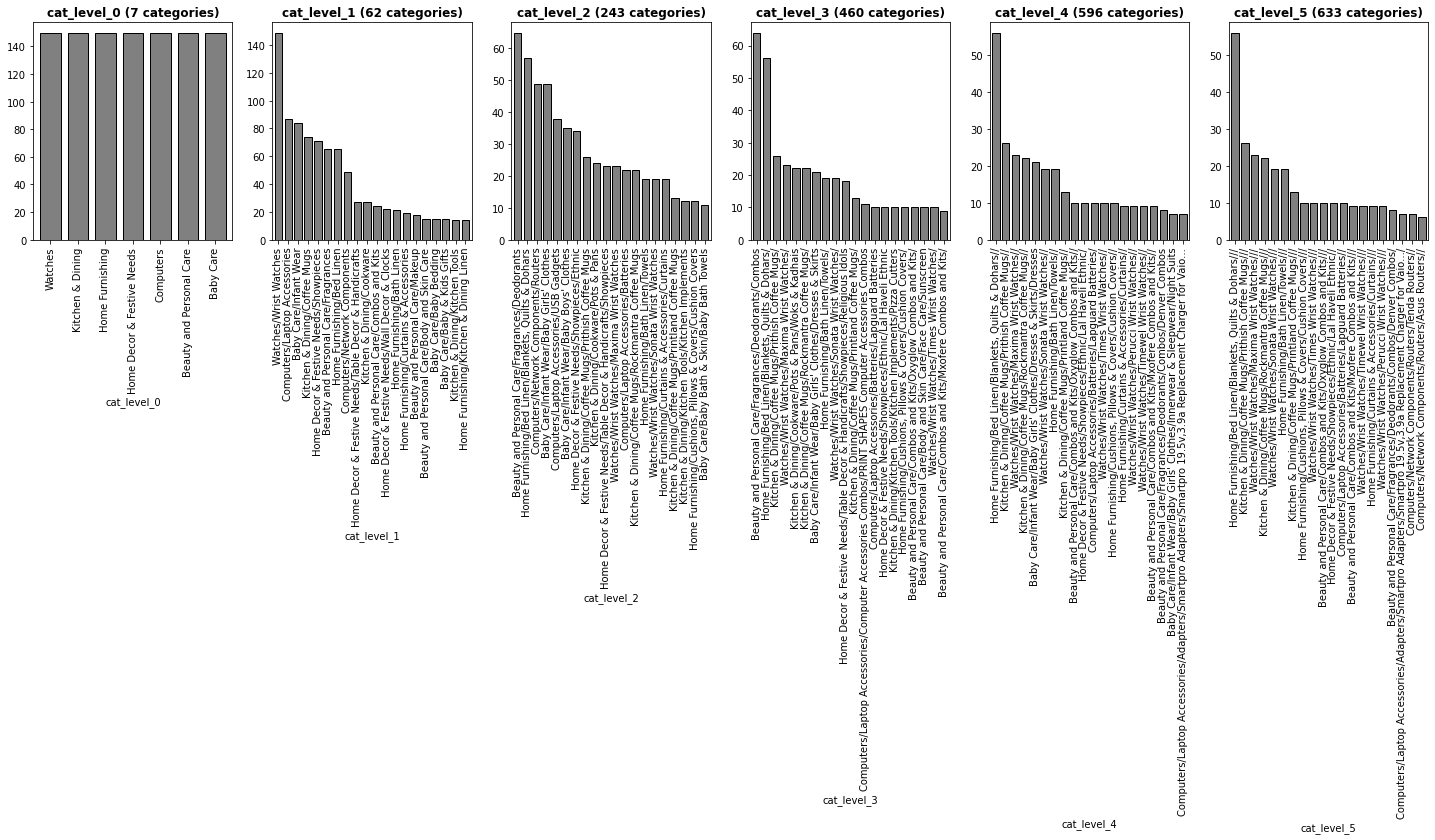

In [24]:
fig = plt.figure(figsize=(25,4))
for i, col in enumerate(df_cat_level.columns,1):
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:20].plot.bar(width=0.75, color='grey', ec='k', ax=ax)
    ax.set_title(col+f' ({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [25]:
df_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [26]:
df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                        'Baby Care': 'Baby', 
                                        'Watches': 'Watches',
                                        'Home Decor & Festive Needs': 'Decor',
                                        'Kitchen & Dining': 'Kitchen',
                                        'Beauty and Personal Care': 'Beauty',
                                        'Computers': 'Computers'})

### 1.2 Products descriptions

In [27]:
# extracting only useful data
df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

In [28]:
df_desc_cat.head()

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ..."
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C..."


In [29]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc_cat['description'].values)
print("total nb of words in the whole corpus: ", len(corpus.split()))

total nb of words in the whole corpus:  80013


## 2 Whole corpus exploration

In [30]:
import nltk

In [31]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Frequency of words (with stopwords)

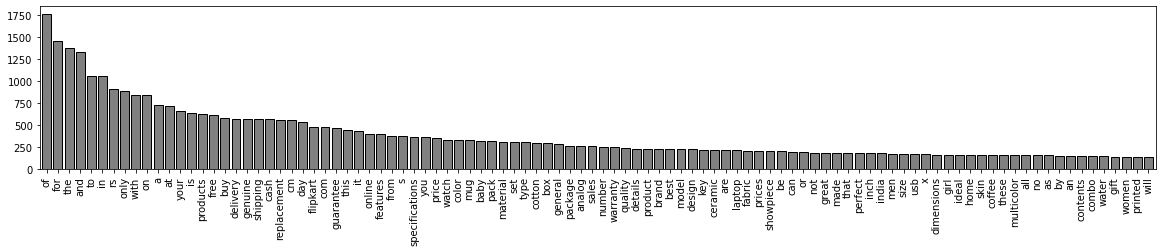

In [32]:
# tokenizing the words in the whole corpus
tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
li_words = tokenizer.tokenize(corpus.lower())
# counting frequency of each word
ser_freq = pd.Series(nltk.FreqDist(li_words))
# plotting the most frequent words
ser_freq.sort_values(ascending=False)[0:100].plot.bar(width=0.8,
                                                            color='grey',
                                                            ec='k')
plt.gcf().set_size_inches(20,3)

In [33]:
english_sw = nltk.corpus.stopwords.words('english')
most_freq_sw = (ser_freq.sort_values(ascending=False)[0:36].index).tolist()
most_freq_sw = [s for s in most_freq_sw if s not in english_sw]
single_let_sw = list(string.ascii_lowercase)
single_let_sw = [s for s in single_let_sw if (s not in most_freq_sw) and\
                                             (s not in english_sw)]

#### Frequency of words without stopwords

In [34]:
# creating a list of stopwords...
sw = set()
# ...including the 36 most frequent words ...
most_freq = (ser_freq.sort_values(ascending=False)[0:36].index).tolist()
sw.update(most_freq)
print("Most frequent words added to stopwords: ", most_freq)
# ...including the single letters ...
single_letters = list(string.ascii_lowercase)
sw.update(single_letters)
# ... as well a known english stopwords from nltk package
sw.update(tuple(nltk.corpus.stopwords.words('english')))
print("Total number of stopwords in sw list: ", len(sw))

Most frequent words added to stopwords:  ['of', 'for', 'the', 'and', 'to', 'in', 'rs', 'only', 'with', 'on', 'a', 'at', 'your', 'is', 'products', 'free', 'buy', 'delivery', 'genuine', 'shipping', 'cash', 'replacement', 'cm', 'day', 'flipkart', 'com', 'guarantee', 'this', 'it', 'online', 'features', 'from', 's', 'specifications', 'you', 'price']
Total number of stopwords in sw list:  215


In [35]:
ser_freq_wo_sw = ser_freq.loc[[s for s in ser_freq.index if s not in sw]]

o---Total number of words: 46445
o---Words in decreasing order of frequency:
watch         330
color         328
mug           327
baby          320
pack          317
             ... 
showcasing      1
rural           1
fascinates      1
purposes        1
nightmares      1
Length: 5057, dtype: int64


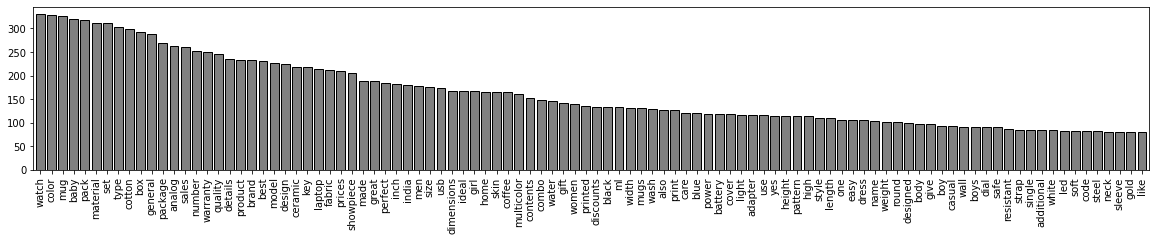

In [36]:
# plotting the most frequent words
print("o---Total number of words: {}\no---Words in decreasing order of\
 frequency:\n{}".format(ser_freq_wo_sw.sum(),
                        ser_freq_wo_sw.sort_values(ascending=False)))
ser_freq_wo_sw.sort_values(ascending=False)[0:100].plot.bar(width=0.8,
                                                            color='grey',
                                                            ec='k')
plt.gcf().set_size_inches(20,3)

#### Frequency of stems

In [37]:
## Lemmatization
# WordNetLemmatizer

In [38]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()
ser_freq_stems = pd.Series(ser_freq_wo_sw.values,
                           index=[stemmer.stem(s) for s in ser_freq_wo_sw.index])\
                   .to_frame().reset_index().groupby('index').sum()
ser_freq_stems = pd.Series(ser_freq_stems.iloc[:,0].values,
                           index = ser_freq_stems.index)

o---Total number of words: 46445
o---Words in decreasing order of frequency:
index
mug        457
design     401
color      380
watch      360
pack       342
          ... 
horizon      1
hop          1
smog         1
cvpc         1
sunflow      1
Length: 4062, dtype: int64


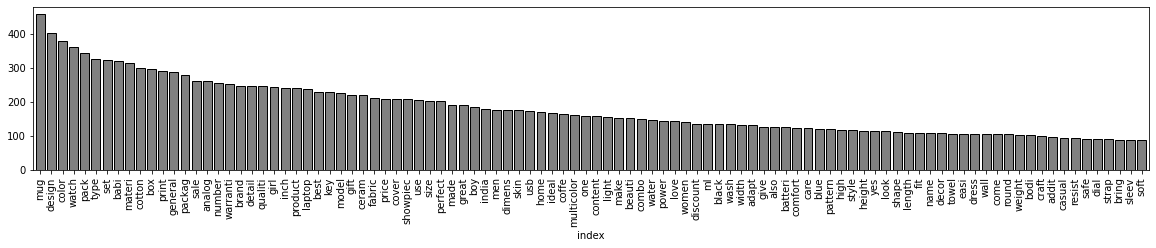

In [39]:
# plotting the most frequent stems
print("o---Total number of words: {}\no---Words in decreasing order of\
 frequency:\n{}".format(ser_freq_stems.sum(),
                        ser_freq_stems.sort_values(ascending=False)))
ser_freq_stems.sort_values(ascending=False)[0:100].plot.bar(width=0.8,
                                                            color='grey',
                                                            ec='k')
plt.gcf().set_size_inches(20,3)

## 3 Text pre-processing


### 3.1 Tokenization - stopwords cleaning - stemming

- regex selection of alphabetical data
- removing stopwords
- removing 36 most frequent words
- stemming

In [40]:
''' from a sentence, containing words (document):
- tokenizes the words if only composed of alphanumerical data,
- removes stopwords if list is given (stopwords)
- stems the words if stemmer given
NB: This pre-processing function can be used to prepare data for Word2Vec
'''
from nltk.stem.snowball import EnglishStemmer

def tokenize_clean(document, stopwords=None, stemmer=None):
    # tokenizing the words in each description
    tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
    li_words = tokenizer.tokenize(document.lower())
    if stopwords is None: stopwords=[]
    # stemming and removing stopwords
    if stemmer is not None:
        li_words = [stemmer.stem(s) for s in li_words if s not in stopwords]
    else:
        # removing stopwords only
        li_words = [s for s in li_words if s not in stopwords]
    return li_words

In [41]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()
df_desc_cat['desc_token'] = \
    df_desc_cat['description'].apply(lambda x: tokenize_clean(x,
                                                              stopwords=sw,
                                                              stemmer=stemmer))

In [42]:
df_desc_cat['desc_token_joined'] = \
    df_desc_cat['desc_token'].apply(lambda x: ' '.join(x))

In [43]:
print(df_desc_cat.shape[0], "different descriptions")
df_desc_cat.head()

1050 different descriptions


,category,product_name,description,desc_token,desc_token_joined
uniq_id,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...","[key, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtain, eleg, polyest...",key eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor ...
7b72c92c2f6c40268628ec5f14c6d590,Baby,Sathiyas Cotton Bath Towel,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...","[sathiya, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, machin, washabl, yes...",sathiya cotton bath towel bath towel red yellow blue bath towel machin washabl yes materi cotton...
64d5d4a258243731dc7bbb1eef49ad74,Baby,Eurospa Cotton Terry Face Towel Set,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...","[key, eurospa, cotton, terri, face, towel, set, size, small, height, inch, gsm, eurospa, cotton,...",key eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri face tow...
d4684dcdc759dd9cdf41504698d737d8,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,"[key, santosh, royal, fashion, cotton, print, king, size, doubl, bedsheet, royal, bedsheet, perf...",key santosh royal fashion cotton print king size doubl bedsheet royal bedsheet perfact wed gift ...
6325b6870c54cd47be6ebfbffa620ec7,Furnishing,Jaipur Print Cotton Floral King sized Double Bedsheet,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...","[key, jaipur, print, cotton, floral, king, size, doubl, bedsheet, cotton, jaipur, print, cotton,...",key jaipur print cotton floral king size doubl bedsheet cotton jaipur print cotton floral king s...


In [44]:
big_list = list(df_desc_cat['desc_token'].values)
all_terms = [s for sublist in big_list for s in sublist]
print("Total number of words in all the descriptions (with duplicates) :",
      len(all_terms))
print("Total number of words in all the descriptions (unique) :",
      len(set(all_terms)))

Total number of words in all the descriptions (with duplicates) : 46445
Total number of words in all the descriptions (unique) : 4062


### 3.2 Document-Term Matrices (BOW and TF-IDF)

#### Bag of words using CountVectorizer

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words = sw,
                    #   min_df = 3,
                    #   max_df = 70,
                      max_features = 1600,
                      )

CV_TD_mat = vec.fit_transform(df_desc_cat['description'])
print( "Created %d X %d document-term matrix" % (CV_TD_mat.shape[0],
                                                 CV_TD_mat.shape[1]) )

# Vocabulary of the document_term matrix
CV_voc = vec.get_feature_names()
print("Vocabulary has %d distinct terms" % len(CV_voc))

CV_TD_df = pd.DataFrame(CV_TD_mat.todense(),
             index=df_desc_cat.index, # each item
             columns=CV_voc) # each word

Created 1050 X 1600 document-term matrix
Vocabulary has 1600 distinct terms


In [46]:
# New Stopwords list generated because of CountVectorizer parameters
CV_sw = vec.stop_words_
print("Old stop-words list has %d entries" % len(sw) )
print("New stop-words list has %d entries" % len(CV_sw))

Old stop-words list has 215 entries
New stop-words list has 4322 entries


Let's look at a representation of the categories on a projection of the data

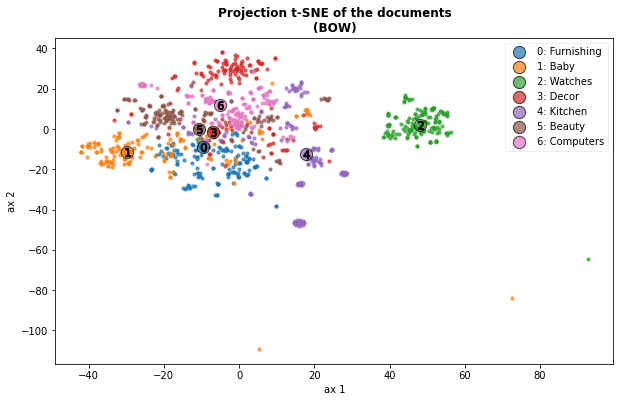

In [47]:
# BOW projection

ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

plot_projection(CV_TD_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the documents\n(BOW)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

#### TF_IDF matrix using TfidfVectorizer

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words=sw,
                            #   min_df = 3,
                            #   max_df = 70,
                            max_features = 1600
                            )
TFIDF_TD_mat = tfidf_vec.fit_transform(df_desc_cat['description'])
print( "Created %d X %d TF-IDF-normalized document-term matrix"\
      % (TFIDF_TD_mat.shape[0], TFIDF_TD_mat.shape[1]) )

# Vocabulary of the document_term matrix
TFIDF_voc = tfidf_vec.get_feature_names()
print("Vocabulary has %d distinct terms" % len(TFIDF_voc))

TFIDF_TD_df = pd.DataFrame(TFIDF_TD_mat.todense(),
                           index=df_desc_cat.index, # each item
                           columns=TFIDF_voc) # each word

Created 1050 X 1600 TF-IDF-normalized document-term matrix
Vocabulary has 1600 distinct terms


In [49]:
# New Stopwords list genearated because of CountVectorizer parameters
TFIDF_sw = tfidf_vec.stop_words_
print("Old stop-words list has %d entries" % len(sw) )
print("New stop-words list has %d entries" % len(TFIDF_sw))

Old stop-words list has 215 entries
New stop-words list has 4322 entries


Let's look at a representation of the categories on a projection of the data

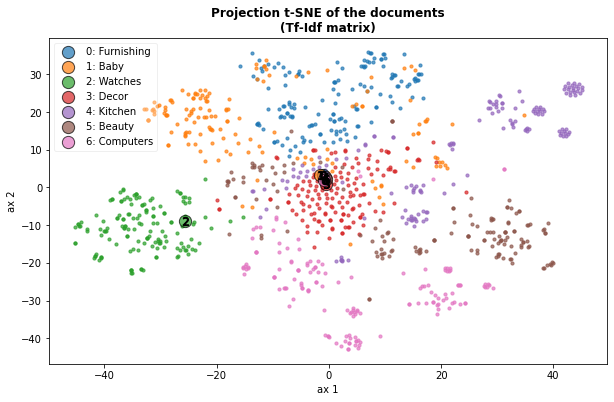

In [50]:
# TF-IDF projection

ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

plot_projection(TFIDF_TD_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the documents\n(Tf-Idf matrix)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

### 3.3 Word embeddings

#### Wiki2Vec embedding

Let's use a word embedding to get a smarter and smaller representation of our data.
We'll use a pre-trained Word2Vec model (our data are too small to train a model).

In [51]:
from wikipedia2vec import Wikipedia2Vec

In [52]:
## Option 2: using a pretrained model
# https://wikipedia2vec.github.io/wikipedia2vec/pretrained/


In [53]:
wiki2vec = Wikipedia2Vec.load("../DATA/enwiki_20180420_100d.pkl") # 100 dimensions

In [54]:
# Vectorization of the descriptions prior to projection on Wiki2Vec

# from nltk.stem.snowball import EnglishStemmer
# stemmer = EnglishStemmer()

tf_idf_df, actu_sw = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 1,
                                    #    'max_df': 15,
                                       'stop_words': sw},
                         tfidf_on=True)

In [55]:
# Projection of the document_term matrix on the w2v matrix 

wiki2vec_emb_df = proj_term_doc_on_w2v(tf_idf_df, wiki2vec, print_opt=False)

Let's look at a representation of the categories on a projection of the data

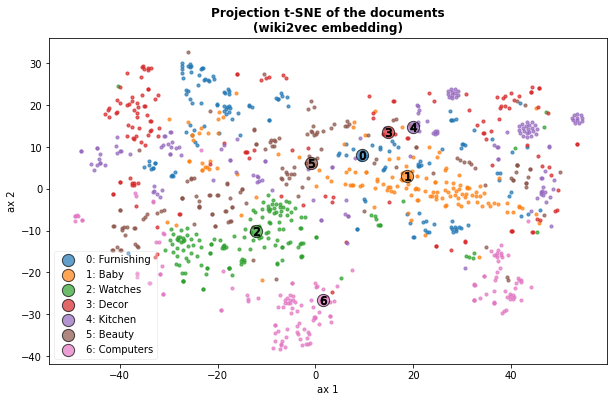

In [56]:
# tfidf_Wiki2Vec_emb projection

ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

plot_projection(wiki2vec_emb_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the documents\n(wiki2vec embedding)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

#### Training a Word2Vec model on the corpus (gensim)

In [57]:
## Option 1: training a Word2Vec model on the whole corpus

from gensim.models.word2vec import Word2Vec

cust_w2v = Word2Vec(df_desc_cat['desc_token'], # works on lists of tokenized stemmed words
                 size=300,
                 window=20,
                 min_count=2,
                 workers=1,
                 iter=100,
                 sg=1)  #0: CBOW, 1:skip-gram)
cust_w2v_vocab = cust_w2v.wv.vocab
print( "Model has %d terms" % len(cust_w2v_vocab))

# pickle the model
cust_w2v.save('P6_trained_w2v.bin')

# # reload
# w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

Model has 2978 terms


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [58]:
# Vectorization of the descriptions prior to projection on Wiki2Vec

# from nltk.stem.snowball import EnglishStemmer
# stemmer = EnglishStemmer()

tf_idf_df, actu_sw = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 1,
                                    #    'max_df': 15,
                                       'stop_words': sw},
                         tfidf_on=True)

In [59]:
# examples
cust_w2v.wv['polyest'].shape, cust_w2v.wv['polyest'][:10]

((300,),
 array([ 0.01910846,  0.03796023, -0.7405385 , -0.3781447 ,  0.09369945,
        -0.08905803, -0.06453358,  0.31186002, -0.16507605,  0.20111318],
       dtype=float32))

In [60]:
tf_idf_df.shape, cust_w2v.wv.vectors.shape

((1050, 5057), (2978, 300))

In [61]:
## A REPARER (ATTRIBUT GET_WORD)
# # Projection of the document_term matrix on the w2v matrix 

# custom_w2v_emb_df = proj_term_doc_on_w2v(tf_idf_df, cust_w2v, print_opt=True)

# # projection of the Document_terms matrix on the wiki2vec (manually, as the vocabulary is the same)
# w2v_emb_df = tf_idf_df.dot(custom_w2v_emb_df)

Let's look at a representation of the categories on a projection of the data

In [62]:
# # tfidf_Word2Vec_emb projection

# ser_categories = pd.Series(df_desc_cat['category'].values, 
#                            index=df_desc_cat.index,
#                            name='Clust')

# plot_projection(custom_w2v_emb_df, model=None, ser_clust=ser_categories,
#                 proj='t-SNE', size=10, legend_on=True,
#                 title="Projection t-SNE of the documents\n(wiki2vec embedding)",
#                 figsize=(10, 6), palette='tab10',
#                 fig=None, ax=None, random_state=14)

## 4 Visualization of the vectorizations with respect to the known categories

In [63]:
'''
'params' are the arguments of the 'compute_doc_terms_df' function and
take the form (default settings):
    preproc_func=None,
    preproc_func_params=None,
    vec_params = {'min_df': 1},
    tfidf_on=False,
    print_opt=False
'''

from sklearn.metrics import silhouette_score

def plot_grid_proj_params(ser_desc, ser_clust, params, n_rows=1,
                          w2v=None, title=None, figsize=(20,10)): 

    n_cols = len(params)//n_rows + ((len(params)%n_rows)>0)*1

    fig = plt.figure()
    fig.set_size_inches(figsize)

    df_scores = pd.DataFrame()
    # Loops over the parameter to show the projections
    for i, param in enumerate(params,1):

        ax = fig.add_subplot(n_rows, n_cols, i)
        # Vectorization of the descriptions prior to projection on Wiki2Vec
        doc_term_df, actu_sw = compute_doc_terms_df(ser_desc, **param)

        # Projection of the document_term matrix on the w2v matrix
        if w2v is not None:
            doc_term_df = proj_term_doc_on_w2v(doc_term_df, w2v)

        # Computing scores
        silh = silhouette_score(doc_term_df, ser_clust)
        df_scores.loc[i-1,'silh'] = silh

        # tfidf_Wiki2Vec_emb projection
        plot_projection(doc_term_df, model=None, ser_clust=ser_clust,
                        proj='t-SNE', size=10, legend_on=True,
                        title="param set n°{}|silh.={:.2f}".format(i, silh),
                        fig=fig, ax=ax, random_state=14)
        
    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout(rect=(0,0,1,0.92))
    else:
        plt.tight_layout()
    plt.show()
    return df_scores

Document-terms matrices (BOW and TfIdf)

Range of min_df tested:
[ 0 12 24 36 48 60]


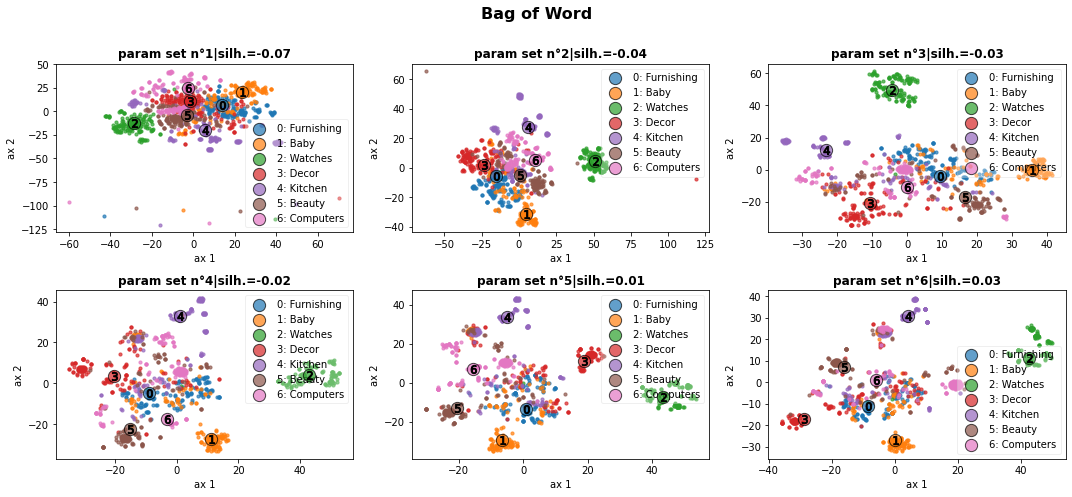

,0,1,2,3,4,5
silh,-0.07,-0.04,-0.03,-0.02,0.01,0.03


In [64]:
####### BOW: min_df#######
ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

# Generates a list of parameters dictionaries
min_df_range = (np.linspace(0,60,6)).astype('int')
params = []
for min_df in min_df_range:
    params.append({'vec_params': {'min_df': min_df, 'stop_words': sw},
                   'tfidf_on': False})

print(f"Range of min_df tested:\n{min_df_range}")
df_scores = plot_grid_proj_params(df_desc_cat['description'],
                                  ser_categories,
                                  params, n_rows=2,
                                  figsize=(15,7),
                                  w2v=None, title="Bag of Word")

display(df_scores.T)

Range of min_df tested:
[ 0 12 24 36 48 60]


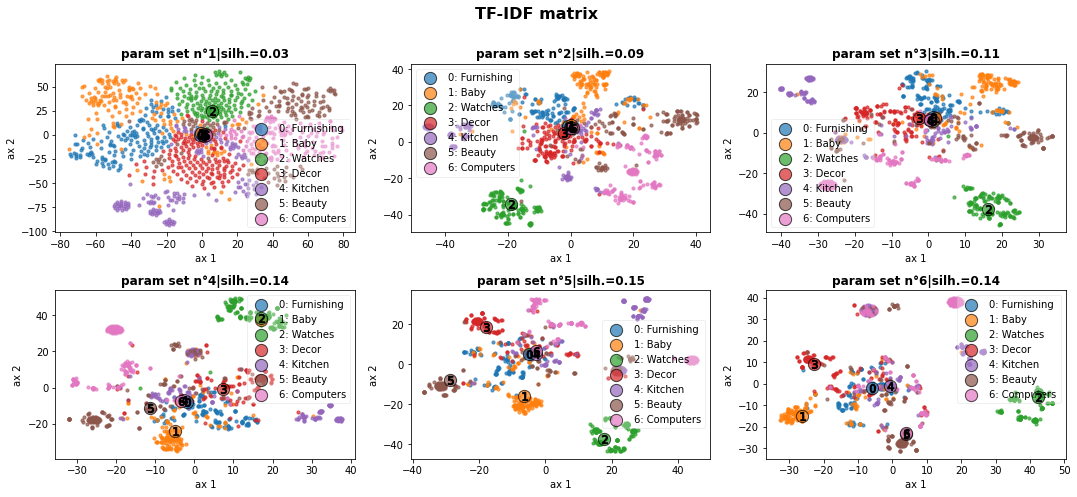

,0,1,2,3,4,5
silh,0.03,0.09,0.11,0.14,0.15,0.14


In [65]:
####### TF_IDF: min_df#######
ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

# Generates a list of parameters dictionaries
min_df_range = (np.linspace(0,60,6)).astype('int')
params = []
for min_df in min_df_range:
    params.append({'vec_params': {'min_df': min_df, 'stop_words': sw},
                   'tfidf_on': True})

print(f"Range of min_df tested:\n{min_df_range}")
df_scores = plot_grid_proj_params(df_desc_cat['description'],
                                  ser_categories,
                                  params, n_rows=2,
                                  figsize=(15,7),
                                  w2v=None, title='TF-IDF matrix')

display(df_scores.T)

Document-terms matrices (BOW and TfIdf) with W2V projection

Range of min_df tested:
[ 0 12 24 36 48 60]


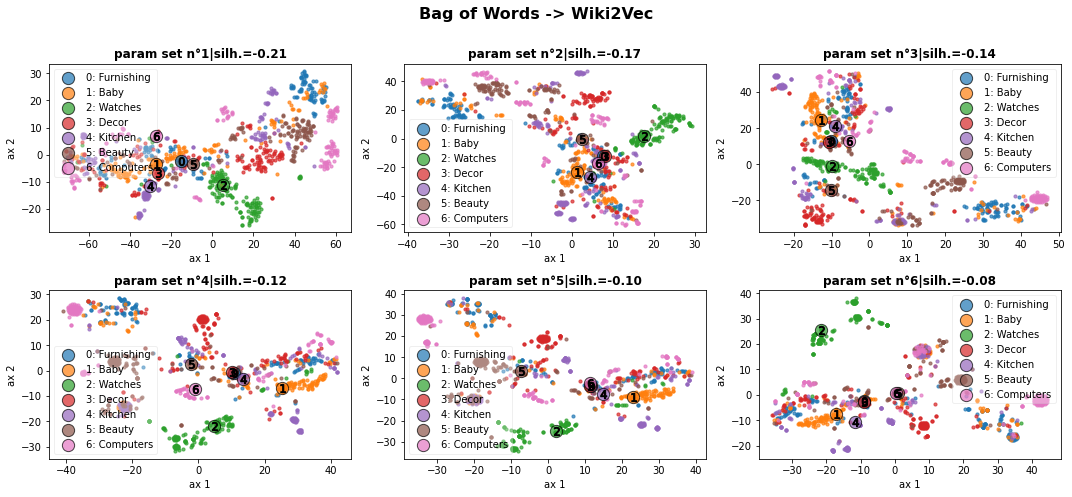

,0,1,2,3,4,5
silh,-0.21,-0.17,-0.14,-0.12,-0.10,-0.08


In [66]:
####### BOW->W2V: min_df#######
ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

# Generates a list of parameters dictionaries
min_df_range = (np.linspace(0,60,6)).astype('int')
params = []
for min_df in min_df_range:
    params.append({'vec_params': {'min_df': min_df, 'stop_words': sw},
                   'tfidf_on': False})

print(f"Range of min_df tested:\n{min_df_range}")
df_scores = plot_grid_proj_params(df_desc_cat['description'],
                                  ser_categories,
                                  params, n_rows=2,
                                  figsize=(15,7),
                                  w2v=wiki2vec,
                                  title='Bag of Words -> Wiki2Vec')

display(df_scores.T)

Range of min_df tested:
[ 0 12 24 36 48 60]


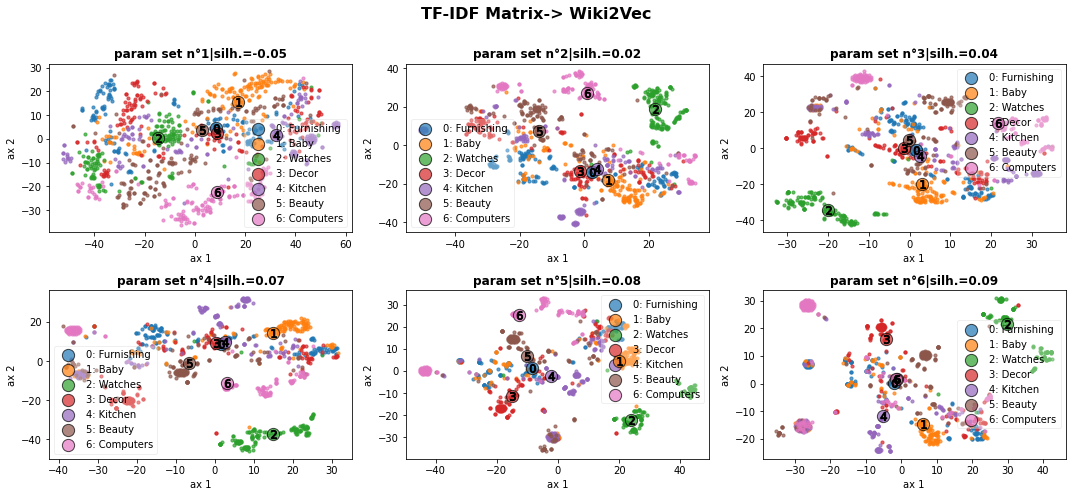

,0,1,2,3,4,5
silh,-0.05,0.02,0.04,0.07,0.08,0.09


In [67]:
####### BOW->W2V: min_df#######
ser_categories = pd.Series(df_desc_cat['category'].values, 
                           index=df_desc_cat.index,
                           name='Clust')

# Generates a list of parameters dictionaries
min_df_range = (np.linspace(0,60,6)).astype('int')
params = []
for min_df in min_df_range:
    params.append({'vec_params': {'min_df': min_df, 'stop_words': sw},
                   'tfidf_on': True})

print(f"Range of min_df tested:\n{min_df_range}")
df_scores = plot_grid_proj_params(df_desc_cat['description'],
                                  ser_categories,
                                  params, n_rows=2,
                                  figsize=(15,7),
                                  w2v=wiki2vec,
                                  title='TF-IDF Matrix-> Wiki2Vec')

display(df_scores.T)

## 5 Topics Modeling

We'll create a dataframe where we'll put the results of the best results of clustering or topics modeling obtained with different techniques.

In [68]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

### 5.1 Categories Modeling using NMF

In [69]:
# create the model
from sklearn.decomposition import NMF
k=7 # number of categories
nmf = NMF(init="nndsvd",
          n_components=k) 

Preprocessing and vectorization of the data

In [70]:
# Vectorization of the descriptions prior to applying NMF

tf_idf_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 10,
                                       'stop_words': sw},
                         tfidf_on=True)

Let's have a look to the 2 matrices documents/topics ans topics/words

In [71]:
# DOCUMENTS/TOPICS Matrix
W = pd.DataFrame(nmf.fit_transform(tf_idf_df.values),
                 index=tf_idf_df.index, # documents
                 columns=['clust_'+str(i) for i in range(1,k+1)]) # topics
# TOPICS/WORDS Matrix
H = pd.DataFrame(nmf.components_,
                 index=['clust_'+str(i) for i in range(1,k+1)], # topics
                 columns=tf_idf_df.columns) # words
print(W.shape, H.shape)

(1050, 7) (7, 539)


#### Categories descriptors

Let's have a look to the top words for each category.

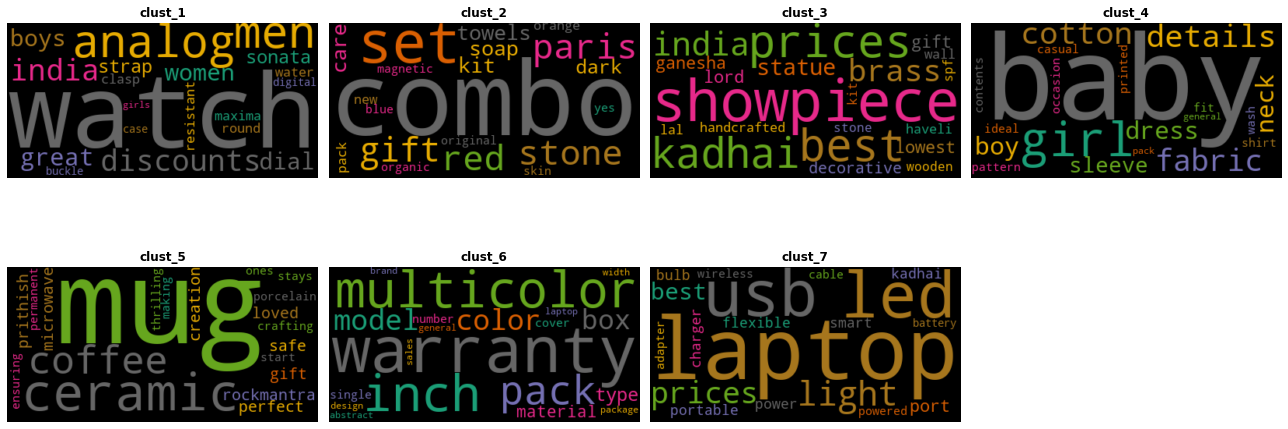

In [72]:
plot_wordclouds_topwords(H, n_top_words=20, n_rows=2)

In [73]:
# printing 10 top words for each topic
for i in H.index:
    print(i, '---', H.loc[i].sort_values(ascending=False)[0:10].index.tolist())
    print(i, '---',
          np.round(H.loc[i].sort_values(ascending=False)[0:10].values.tolist(),2))

clust_1 --- ['watch', 'analog', 'men', 'discounts', 'india', 'great', 'women', 'boys', 'dial', 'strap']
clust_1 --- [1.52 1.39 0.94 0.74 0.72 0.69 0.64 0.39 0.38 0.36]
clust_2 --- ['combo', 'set', 'paris', 'stone', 'red', 'gift', 'towels', 'soap', 'kit', 'care']
clust_2 --- [2.06 1.94 0.13 0.1  0.09 0.09 0.09 0.07 0.07 0.07]
clust_3 --- ['showpiece', 'prices', 'best', 'kadhai', 'india', 'brass', 'statue', 'ganesha', 'lord', 'lowest']
clust_3 --- [2.28 1.19 1.13 0.27 0.17 0.16 0.14 0.14 0.1  0.1 ]
clust_4 --- ['baby', 'girl', 'details', 'cotton', 'fabric', 'dress', 'boy', 'neck', 'sleeve', 'pattern']
clust_4 --- [1.07 0.71 0.64 0.57 0.56 0.46 0.43 0.35 0.34 0.29]
clust_5 --- ['mug', 'ceramic', 'coffee', 'rockmantra', 'perfect', 'prithish', 'gift', 'loved', 'safe', 'microwave']
clust_5 --- [1.15 0.85 0.42 0.4  0.35 0.33 0.33 0.3  0.29 0.27]
clust_6 --- ['warranty', 'multicolor', 'inch', 'pack', 'color', 'model', 'box', 'type', 'material', 'number']
clust_6 --- [0.41 0.41 0.41 0.4  0.4  0

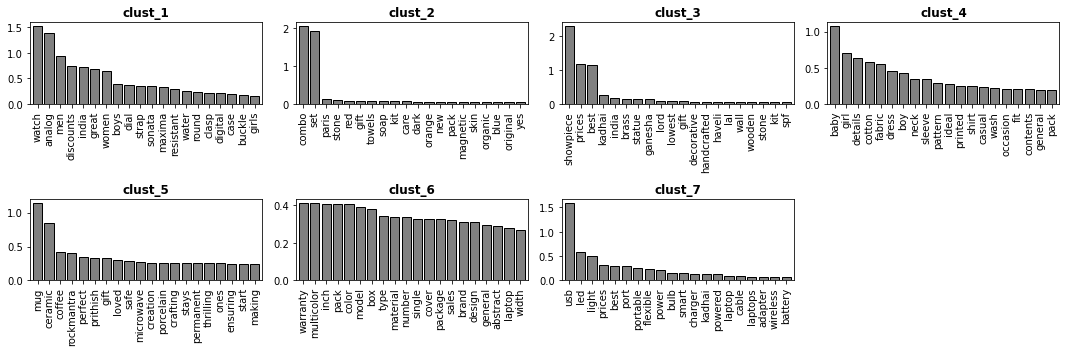

In [74]:
# plotting bar plots fo 20 top words for each topic
n_rows = 2
fig= plt.figure(figsize=(15,5))
for i, cat in enumerate(H.index, 1):
    n_tot = H.shape[0]
    n_cols = n_tot//n_rows + (n_tot%n_rows!=0)*1
    ax=fig.add_subplot(n_rows, n_cols, i)
    H.loc[cat].sort_values(ascending=False).iloc[0:20].plot.bar(color='grey',
                                                                width=0.8,
                                                                ec='k', ax=ax)
    ax.set_title(cat, fontweight='bold')
plt.tight_layout()
plt.show()

#### Most relevant items for each category

In [75]:
# 3 most relevant items for each categories
categories = ['clust_'+str(i) for i in range(1,8)]
for cat in categories:
    ser = W.loc[:,cat].sort_values(ascending=False)[0:3]
    print('-'*20+cat.upper()+'-'*20)
    display(df_desc_cat.loc[ser.index, ['product_name', 'description']])

--------------------CLUST_1--------------------


,product_name,description
uniq_id,,
49658948b5f4eb06a3ddc2fa75eb41d0,Hourglass HG 006 Analog Watch - For Men,Hourglass HG 006 Analog Watch - For Men - Buy Hourglass HG 006 Analog Watch - For Men HG 006 ...
170fdf050c7a1f8d30ef5a98c4216f9c,R.S D&G16 Analog Watch - For Men,R.S D&G16 Analog Watch - For Men - Buy R.S D&G16 Analog Watch - For Men D&G16 Online at Rs.24...
6c53dbd7a9d43744920bfae3bc06327f,Timewel 1100-N31 Analog Watch - For Men,Timewel 1100-N31 Analog Watch - For Men - Buy Timewel 1100-N31 Analog Watch - For Men 1100-N3...


--------------------CLUST_2--------------------


,product_name,description
uniq_id,,
4c096ad79f63c12a42f56fe8cec37f36,Adidas Ice Dive Combo Set,Flipkart.com: Buy Adidas Ice Dive Combo Set online only for Rs. 380 from Flipkart.com. Only Genu...
4b0e6f200426b1db8824b2ca0c59ecfa,"Park Avenue Believe Spray ,Four Seasons EDP Combo Set","Flipkart.com: Buy Park Avenue Believe Spray ,Four Seasons EDP Combo Set online only for Rs. 389 ..."
07f8bdc4372a73d0820507683a936b6e,Playboy London And Malibu Combo Set,Flipkart.com: Buy Playboy London And Malibu Combo Set online only for Rs. 360 from Flipkart.com....


--------------------CLUST_3--------------------


,product_name,description
uniq_id,,
9833d0de7f7e1927c807411c10b19189,Ruchikainternational ruc0015 Showpiece - 4 cm,Buy Ruchikainternational ruc0015 Showpiece - 4 cm for Rs.499 online. Ruchikainternational ruc0...
26d8d458084ef90d395d303eaeb71587,Nihar Pirangi Bomber Showpiece - 10 cm,Buy Nihar Pirangi Bomber Showpiece - 10 cm for Rs.194 online. Nihar Pirangi Bomber Showpiece ...
81a695f80d3f5c445910d310f1a83eb8,S C Handicrafts Sandalwood Chinese Queen. Showpiece - 16 cm,Buy S C Handicrafts Sandalwood Chinese Queen. Showpiece - 16 cm for Rs.8500 online. S C Handic...


--------------------CLUST_4--------------------


,product_name,description
uniq_id,,
7f7c64d439d64656d6baa40f5798cdf5,"Kandyfloss Baby Boy's, Baby Girl's Romper","Key Features of Kandyfloss Baby Boy's, Baby Girl's Romper Fabric: COTTON Brand Color: RED,Specif..."
6e812fbc03331ab363789b0f2d6b3ff2,Titrit Baby Girl's Gathered Dress,Key Features of Titrit Baby Girl's Gathered Dress Baby Frock With Shrug And Legging Material Cot...
68b32e026c109c1bae017d024dd8f590,MKB Baby Girl's Empire Waist Dress,Key Features of MKB Baby Girl's Empire Waist Dress Material: 100% Cotton Yellow Flower Print Len...


--------------------CLUST_5--------------------


,product_name,description
uniq_id,,
8bf65b132179faf26f61e26274b2b819,Rockmantra Gamming Wallpaper Ceramic Mug,Rockmantra Gamming Wallpaper Ceramic Mug (5.5 l)\r\n Price: Rs. 349\r\n\...
7956d9586de3e25ff586bca58be7195e,Rockmantra 3d Flawers 2 Ceramic Mug,Rockmantra 3d Flawers 2 Ceramic Mug (5.5 l)\r\n Price: Rs. 199\r\n\t\t\t...
f8794f7a06b530782c66f7c0911bb437,Rockmantra Fantasy ArtRMMW50000330 Ceramic Mug,Rockmantra Fantasy ArtRMMW50000330 Ceramic Mug (5.5 l)\r\n Price: Rs. 19...


--------------------CLUST_6--------------------


,product_name,description
uniq_id,,
7cbbe686c4a233e8cf53528748f75223,Remtex Export Cartoon Single Dohar Multicolor,Specifications of Remtex Export Cartoon Single Dohar Multicolor (1 Dohar) In the Box Sales Packa...
2231a6fc63274c46043e353f1728f077,Tidy Printed Cushions Cover,"Key Features of Tidy Printed Cushions Cover 100% Pure Cotton High Quality Excellent Design,Speci..."
66191b4a311b5d9babfc00a71ef97c5b,JMD Printed Cushions Cover,"Key Features of JMD Printed Cushions Cover Printed 40x40cm size Made of Cotton,Specifications of..."


--------------------CLUST_7--------------------


,product_name,description
uniq_id,,
e86daf9ebcdfc5c5dd088cdb7f8f8db6,Epresent Mfan 1 Fan USB USB Fan,Buy Epresent Mfan 1 Fan USB USB Fan for Rs.219 online. Epresent Mfan 1 Fan USB USB Fan at best p...
c612bdfa459e1e2f20d57348336c24be,QP360 Kid Fan 01 MLY2015 USB USB Fan,Buy QP360 Kid Fan 01 MLY2015 USB USB Fan for Rs.489 online. QP360 Kid Fan 01 MLY2015 USB USB Fan...
95b0779b1a04ab70d62c72b53090c4b3,Orico USB 3.0 Hub with Card Reader H3TS-U3-BK USB USB Hub,Buy Orico USB 3.0 Hub with Card Reader H3TS-U3-BK USB USB Hub for Rs.1490 online. Orico USB 3.0 ...


In [76]:
# Appending the best results of the NMF topics modeling 
df_res_clust['NMF_tfidf'] = W.idxmax(1)

In [77]:
df_res_clust.sample(5)

,categories,NMF_tfidf
uniq_id,,
8c90f3ca64ea1a8ce104c3c3f5fc173f,Decor,clust_3
8507eb0ef32c1c0db700f20aad6d9bcd,Kitchen,clust_5
7821fb1cbf8d3bb294c3c20527119f15,Beauty,clust_6
26d8d458084ef90d395d303eaeb71587,Decor,clust_3
832a66ce379b4c98fd3d748eebd7ae4c,Computers,clust_7


### 5.2 Categories modeling with LDA

In [78]:
# create the model
from sklearn.decomposition import LatentDirichletAllocation as LDA
k=7 # number of categories

lda = LDA(n_components=k)

Preprocessing and vectorization of the data

In [79]:
# Vectorization of the descriptions prior to applying LDA
tf_idf_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 10,
                                       'stop_words': sw},
                         tfidf_on=True)

Let's have a look to the 2 matrices documents/topics ans topics/words

In [80]:
# DOCUMENTS/TOPICS Matrix
W = pd.DataFrame(lda.fit_transform(tf_idf_df.values),
                 index=tf_idf_df.index, # documents
                 columns=['clust_'+str(i) for i in range(1,k+1)]) # topics
# TOPICS/WORDS Matrix
H = pd.DataFrame(lda.components_,
                 index=['clust_'+str(i) for i in range(1,k+1)], # topics
                 columns=tf_idf_df.columns) # words
print(W.shape, H.shape)

(1050, 7) (7, 539)


#### Categories descriptors

Let's have a look to the top words for each category.

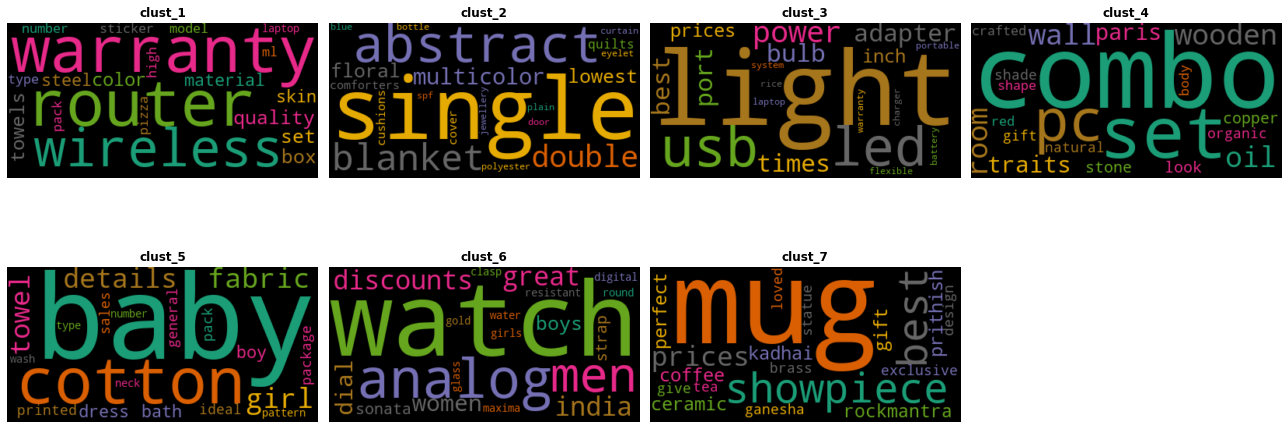

In [81]:
plot_wordclouds_topwords(H, n_top_words=20, n_rows=2)

In [82]:
# printing 10 top words for each topic
for i in H.index:
    print(i, '---', H.loc[i].sort_values(ascending=False)[0:10].index.tolist())
    print(i, '---',
          np.round(H.loc[i].sort_values(ascending=False)[0:10].values.tolist(),2))

clust_1 --- ['warranty', 'router', 'wireless', 'quality', 'set', 'box', 'towels', 'color', 'material', 'steel']
clust_1 --- [10.75 10.51  9.66  9.2   8.61  8.21  8.01  8.01  7.84  7.84]
clust_2 --- ['single', 'abstract', 'blanket', 'double', 'multicolor', 'floral', 'lowest', 'quilts', 'comforters', 'cover']
clust_2 --- [14.91 14.32 14.27 12.61 11.31  9.44  9.43  9.43  9.26  9.02]
clust_3 --- ['usb', 'led', 'light', 'power', 'adapter', 'port', 'bulb', 'times', 'best', 'prices']
clust_3 --- [24.08 13.07  9.11  7.36  6.85  6.55  6.4   6.22  5.61  5.58]
clust_4 --- ['combo', 'set', 'pc', 'wall', 'wooden', 'room', 'oil', 'traits', 'paris', 'copper']
clust_4 --- [45.02 42.05  6.6   5.85  5.52  4.47  4.35  4.13  4.01  3.88]
clust_5 --- ['baby', 'cotton', 'girl', 'fabric', 'details', 'towel', 'dress', 'boy', 'bath', 'printed']
clust_5 --- [29.92 25.6  17.9  16.26 16.2  12.56 11.44 11.27 11.18 10.8 ]
clust_6 --- ['watch', 'analog', 'men', 'discounts', 'india', 'great', 'women', 'dial', 'boys', 

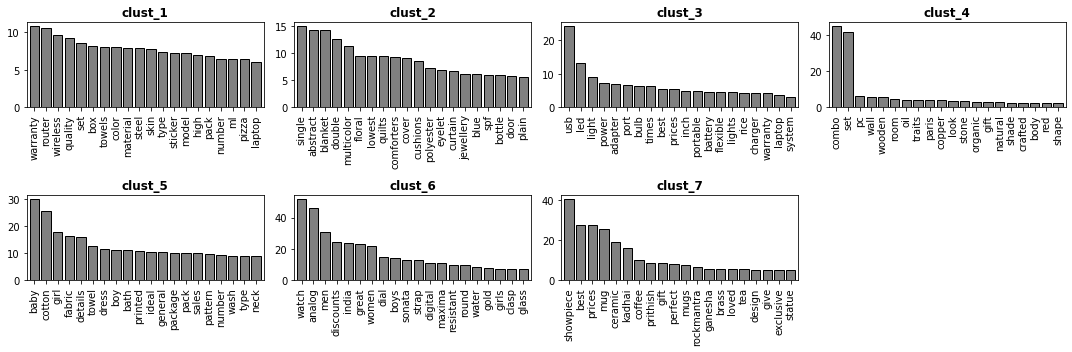

In [83]:
# plotting bar plots fo 20 top words for each topic
n_rows = 2
fig= plt.figure(figsize=(15,5))
for i, cat in enumerate(H.index, 1):
    n_tot = H.shape[0]
    n_cols = n_tot//n_rows + (n_tot%n_rows!=0)*1
    ax=fig.add_subplot(n_rows, n_cols, i)
    H.loc[cat].sort_values(ascending=False).iloc[0:20].plot.bar(color='grey',
                                                                width=0.8,
                                                                ec='k', ax=ax)
    ax.set_title(cat, fontweight='bold')
plt.tight_layout()
plt.show()

#### Most relevant items for each category

In [84]:
# 10 most relevant items for each categories
categories = ['clust_'+str(i) for i in range(1,8)]
for cat in categories:
    ser = W.loc[:,cat].sort_values(ascending=False)[0:10]
    print('-'*20+cat.upper()+'-'*20)
    display(df_desc_cat.loc[ser.index, ['product_name', 'description']])

--------------------CLUST_1--------------------


,product_name,description
uniq_id,,
eeecf5d16fa6591290706f1fd0c6fc6e,PRINT SHAPES red Heart Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES red Heart Laptop Skin with Mouse pad Combo Set Glue Free Removal 15...
5a54c78b52c984e56500809e5bc27ae1,PRINT SHAPES Red bull Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES Red bull Laptop Skin with Mouse pad Combo Set Glue Free Removal 15....
031c98cfde349d99fb6d5983f54c8751,PRINT SHAPES Power of roman reigns Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES Power of roman reigns Laptop Skin with Mouse pad Combo Set Glue Fre...
30ad2acaccdd2e1691a61c44079c2b5a,PRINT SHAPES monster university party Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES monster university party Laptop Skin with Mouse pad Combo Set Glue ...
9b805665a791f40e7946a73dcea17e35,PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set Glue Free Remov...
6057d1b6682ab473a3fe2ca8b4577259,PRINT SHAPES Sony headphone Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES Sony headphone Laptop Skin with Mouse pad Combo Set Glue Free Remov...
b5834f1e97c74d2833dbcb09a3f27926,PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set Glue Free...
7815fb39feb773db944c9f03bbdcbf64,PRINT SHAPES Peacock Feather Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES Peacock Feather Laptop Skin with Mouse pad Combo Set Glue Free Remo...
d407ab825e1a266635214bfe893f29c4,PRINT SHAPES despicable me 2 looking upwards Laptop Skin with Mouse pad Combo Set,Key Features of PRINT SHAPES despicable me 2 looking upwards Laptop Skin with Mouse pad Combo Se...


--------------------CLUST_2--------------------


,product_name,description
uniq_id,,
6eaa9bd9e9285d77891bb76d30e6ebe7,Aroma Comfort Polyester Blue Floral Eyelet Long Door Curtain,Specifications of Aroma Comfort Polyester Blue Floral Eyelet Long Door Curtain (274 cm in Height...
362714cbba2f5ae412d2f26bae99a266,Aroma Comfort Polyester Brown Self Design Eyelet Long Door Curtain,Key Features of Aroma Comfort Polyester Brown Self Design Eyelet Long Door Curtain Height: 274 c...
3f97735a6c61a3587cefceaef36c280c,Aroma Comfort Polyester Green Self Design Eyelet Door Curtain,Key Features of Aroma Comfort Polyester Green Self Design Eyelet Door Curtain Height: 213 cm Wid...
678ebb5f6057dcc51948253c1b39b0b8,Aroma Comfort Polyester Brown Self Design Eyelet Door Curtain,Key Features of Aroma Comfort Polyester Brown Self Design Eyelet Door Curtain Height: 213 cm Wid...
ace154420a51fad090b3543995630051,Aroma Comfort Polyester Dark Blue Plain Eyelet Window Curtain,Key Features of Aroma Comfort Polyester Dark Blue Plain Eyelet Window Curtain Height: 152 cm Wid...
7ec5ac2dea80b6c5e4cfd20eba597d20,Aroma Comfort Polyester Brown Floral Eyelet Long Door Curtain,Key Features of Aroma Comfort Polyester Brown Floral Eyelet Long Door Curtain Height: 274 cm Wid...
90906358dac904c4f05c12c798ac5221,Aroma Comfort Polyester Brown Printed Eyelet Window Curtain,Key Features of Aroma Comfort Polyester Brown Printed Eyelet Window Curtain Height: 182 cm Width...
4748b7ea0e01cffa561f1a7a7a432813,Aroma Comfort Polyester Cream Self Design Eyelet Window Curtain,Key Features of Aroma Comfort Polyester Cream Self Design Eyelet Window Curtain Height: 152 cm W...
db3e2eeb4fe90d4755f2911d661eae95,Bhavya Velvet Sofa Cover,"Bhavya Velvet Sofa Cover (Grey Pack of 10) Price: Rs. 1,999 Bhavya Velvet Sofa Cover (Black Pack..."


--------------------CLUST_3--------------------


,product_name,description
uniq_id,,
ea199e645da893f2ab0c45cf07face13,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR190E/R 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR190E/R 75 Adapter ..."
3ccceaae844f34180708cb6cba3441bf,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR390E/B 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR390E/B 75 Adapter ..."
9fb8662af03c957ade34d4c816d4e903,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR309E 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR309E 75 Adapter De..."
7f2f1f3039d1f5bc23226fc36577eab9,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR13G/L 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR13G/L 75 Adapter D..."
32f24a4303050f500dec7cb3608fe089,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR305E/L 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR305E/L 75 Adapter ..."
4735953b9c8504eb327675a14c6c33dd,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR540E/L 75 Adapter","Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR540E/L 75 Adapter ..."
281dfd9b94b34362c295b3e5f8da5dfa,"Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR490EBW 75 Adapter","Specifications of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR490EBW 75 Adapte..."
209bf06a732416f1ce5147a8b0524808,Lapguard Toshiba Satellite Pro A200 6 Cell Laptop Battery,Lapguard Toshiba Satellite Pro A200 6 Cell Laptop Battery\r\n Price: Rs....
93f45475c82bdee6df73c6e08011b7da,Lapguard SONY VAIO VGN-NW270DB_90 90 Adapter,Lapguard SONY VAIO VGN-NW270DB_90 90 Adapter (Power Cord Included)\r\n P...


--------------------CLUST_4--------------------


,product_name,description
uniq_id,,
a371cfcae8c6ec3b82ae37a83a8ae9b9,Sapatos Plain Single Duvet Blue,Sapatos Plain Single Duvet Blue (1 Piece Brown Single Duvet)\r\n Price: ...
3f9f12fa8fc6d7ebef136040f179a201,Sapatos Plain Single Dohar Fushia,Sapatos Plain Single Dohar Fushia (1 Piece Brown Single Dohar)\r\n Price...
7091af252a785131c5a124fb90705fda,Sapatos Plain Single Duvet Red,"Sapatos Plain Single Duvet Red (Single duvet)\r\n Price: Rs. 1,499\r\n\t..."
5cd3d274d71e1e0d6bf075421461b2d5,Sapatos Geometric Single Duvet Purple & Pink,Sapatos Geometric Single Duvet Purple & Pink (Single duvet)\r\n Price: R...
747b170919791d6111847d3485b5b77b,Good Way Peppermint Lip Balm Pepper,Good Way Peppermint Lip Balm Pepper (8 g) Price: Rs. 85 Refresh your lips with the cool sensatio...
95330f6f0f44d17b918feec36bedcdef,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORTANT COMBO 47,Specifications of RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORTANT COMBO 47 (Set of 4) Combo Se...
5e84d36ad6db970548498829db8b15de,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORTANT COMBO 51,Specifications of RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORTANT COMBO 51 (Set of 4) Combo Se...
0abfcbe0e17dd50c4cf5fb1d6037d514,Brillare Science Dandruff Control Shampoo & Intenso Creme Combo,Specifications of Brillare Science Dandruff Control Shampoo & Intenso Creme Combo (Set of) Combo...
4a1b23dacd7d2a9ec7414f7159f25a48,"Mars Queen Eye Liner, Lip Gloss, EyeLiner","Mars Queen Eye Liner, Lip Gloss, EyeLiner (Set of 3) Price: Rs. 299 1 Queen Eye Liner, 1 Lip Glo..."


--------------------CLUST_5--------------------


,product_name,description
uniq_id,,
9ec6285cc619688d787d641cb87c10d6,Babyoye Premium Baby Girl's Multicolor Leggings,"Key Features of Babyoye Premium Baby Girl's Multicolor Leggings Multicolor Leggings,Babyoye Prem..."
719677b02bfccafb86e9be78f36f938b,Babeezworld Baby Boy's Romper,"Key Features of Babeezworld Baby Boy's Romper Fabric: Cotton Brand Color: Blue:Green,Babeezworld..."
2c8912b849cf73676d025aa99203b6d1,Lula Baby Girl's Dark Blue Bodysuit,Key Features of Lula Baby Girl's Dark Blue Bodysuit Fabric: cotton spandex Brand Color: ROYAL BL...
729864e0d25e06cbf68561529bcdd4f0,CALCULUS Baby Boy's Printed Casual Beige Shirt,Key Features of CALCULUS Baby Boy's Printed Casual Beige Shirt Fit: SLIM Suitable For: Western W...
96bc1fbb83ad5a2c0441d132fe8bcf97,Lilliput Solid Baby Boy's Blue Cargo Shorts,"Key Features of Lilliput Solid Baby Boy's Blue Cargo Shorts Cotton Blue Light,Lilliput Solid Bab..."
7c15895bbfd7da97c219be5b28150a06,Toddla Baby Girl's Gathered Dress,Key Features of Toddla Baby Girl's Gathered Dress Raglan printed dress with beautiful flower on ...
721d6fc10f52e76007c3c0405cf967c5,Toons Printed Baby Boy's Round Neck T-Shirt,"Key Features of Toons Printed Baby Boy's Round Neck T-Shirt stylish,Toons Printed Baby Boy's Rou..."
6ed34e1ab886e8a702ec59dd66ba4dff,Globe Graphic Print Baby Boy's Round Neck Orange T-Shirt,Key Features of Globe Graphic Print Baby Boy's Round Neck Orange T-Shirt Fit: Regular Suitable F...
32da1bbf4f523bc8a8735701ce4b7726,Wow! Baby Girl's Gathered Pink Dress,Key Features of Wow! Baby Girl's Gathered Pink Dress Summer Cotton Frocks Soft Jersey Fabric Sui...


--------------------CLUST_6--------------------


,product_name,description
uniq_id,,
553aa0252537751d153e7c50029f0242,Adino ADF04 Analog Watch - For Girls,Specifications of Adino ADF04 Analog Watch - For Girls General Type Analog Style Code ADF04 Ide...
e2cec0756030a25f294ead3acc0570d2,ESIDON AKADA06 Analog Watch - For Women,Specifications of ESIDON AKADA06 Analog Watch - For Women General Type Analog Style Code AKADA0...
8748b6cd9f03afc539f246c55e230502,"Fastrack 9912PP09 Tees Analog Watch - For Men, Women","Fastrack 9912PP09 Tees Analog Watch - For Men, Women - Buy Fastrack 9912PP09 Tees Analog Watch ..."
64a9d0488652194fd8e879d5e6dc8015,"palito PLO 149 Analog Watch - For Girls, Women","Specifications of palito PLO 149 Analog Watch - For Girls, Women General Type Analog Style Code..."
009099b1f6e1e8f893ec29a7023153c4,"palito PLO 166 Analog Watch - For Girls, Women","Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code..."
052559ede419996737893eb47568ee7f,Maxima 26512PPGN FIBER COLLECTION Analog Watch - For Men,Maxima 26512PPGN FIBER COLLECTION Analog Watch - For Men - Buy Maxima 26512PPGN FIBER COLLECTIO...
3864ab10ef7006452fef45513de8f868,Sonata 7092SL01 Yuva Analog Watch - For Men,Sonata 7092SL01 Yuva Analog Watch - For Men - Buy Sonata 7092SL01 Yuva Analog Watch - For Men ...
b64149a8a9235f5199c6d8225d5dc602,Maxima 29923LPGY Analog Watch - For Men,Maxima 29923LPGY Analog Watch - For Men - Buy Maxima 29923LPGY Analog Watch - For Men 29923LP...
93f01d6cd167fa549928a9b649f87ccc,Global Nomad GNLBBL0314 Analog Watch - For Men,Global Nomad GNLBBL0314 Analog Watch - For Men - Buy Global Nomad GNLBBL0314 Analog Watch - Fo...


--------------------CLUST_7--------------------


,product_name,description
uniq_id,,
9077acd25761ea067ac6d9369d8fdf16,Prithish Eye Abstract Painting Ceramic Mug,Prithish Eye Abstract Painting Ceramic Mug (330 ml)\r\n Price: Rs. 175\r...
219b24362655097cb41bf06a0be8ee79,Prithish Merry Christmas Design 4 Double Color Ceramic Mug,Prithish Merry Christmas Design 4 Double Color Ceramic Mug (330 ml)\r\n ...
beaa6285a2b9c66db0e294767711ca3f,Prithish Better Than Having You For A Husband Double Color Ceramic Mug,Prithish Better Than Having You For A Husband Double Color Ceramic Mug (330 ml)\r\n ...
de911421573d3e234450040374b55b38,Prithish Word of The Day: Bullshit Double Color Ceramic Mug,Prithish Word of The Day: Bullshit Double Color Ceramic Mug (330 ml)\r\n ...
f1484a63c0dc79e96c98b2a250380ed8,Prithish Alphabets With Illustrations Double Color Ceramic Mug,Prithish Alphabets With Illustrations Double Color Ceramic Mug (330 ml)\r\n ...
02127f52e96fb72c66bf081d25104ef8,Prithish Believe In Yourself Double Color Ceramic Mug,Prithish Believe In Yourself Double Color Ceramic Mug (330 ml)\r\n Price...
06749cbff1487f470438823f6952cfd1,Prithish Hop Jump Skip Black Ceramic Mug,Prithish Hop Jump Skip Black Ceramic Mug (330 ml)\r\n Price: Rs. 275\r\n...
73503fe89ea77420a598f4a1019e5b6d,Prithish Pscychological Illusions Design 5 Ceramic Mug,Prithish Pscychological Illusions Design 5 Ceramic Mug (330 ml)\r\n Pric...
a341f915962ee99754e962520f279708,Prithish Never Ever Give Up Ceramic Mug,Prithish Never Ever Give Up Ceramic Mug (330 ml)\r\n Price: Rs. 175\r\n\...


In [85]:
# Appending the best results of the LDA topics modeling 
df_res_clust['LDA_tfidf'] = W.idxmax(1)

In [86]:
df_res_clust.sample(5)

,categories,NMF_tfidf,LDA_tfidf
uniq_id,,,
c3c23b5aa5e388e5f71883f61d1a0561,Decor,clust_3,clust_7
e2ae2af58ac50adf4881751ae84a9d8a,Computers,clust_7,clust_2
3830dda3491cd5b28ed42ae544bc44f0,Kitchen,clust_5,clust_7
0991e8d8f884003ab18890971191085d,Baby,clust_4,clust_5
31ac1b66cc6bb396c83f124317589f8c,Baby,clust_4,clust_5


### 5.3 Categories modeling with LSA

In [87]:
# create the model
from sklearn.decomposition import TruncatedSVD
k=7 # number of categories

lsa = TruncatedSVD(n_components=k)

Preprocessing and vectorization of the data

In [88]:
# Vectorization of the descriptions prior to applying LDA
tf_idf_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 10,
                                       'stop_words': sw},
                         tfidf_on=True)

Let's have a look to the 2 matrices documents/topics ans topics/words

In [89]:
# DOCUMENTS/TOPICS Matrix
W = pd.DataFrame(lsa.fit_transform(tf_idf_df.values),
                 index=tf_idf_df.index, # documents
                 columns=['clust_'+str(i) for i in range(1,k+1)]) # topics
# TOPICS/WORDS Matrix
H = pd.DataFrame(lda.components_,
                 index=['clust_'+str(i) for i in range(1,k+1)], # topics
                 columns=tf_idf_df.columns) # words
print(W.shape, H.shape)

(1050, 7) (7, 539)


#### Categories descriptors

Let's have a look to the top words for each category.

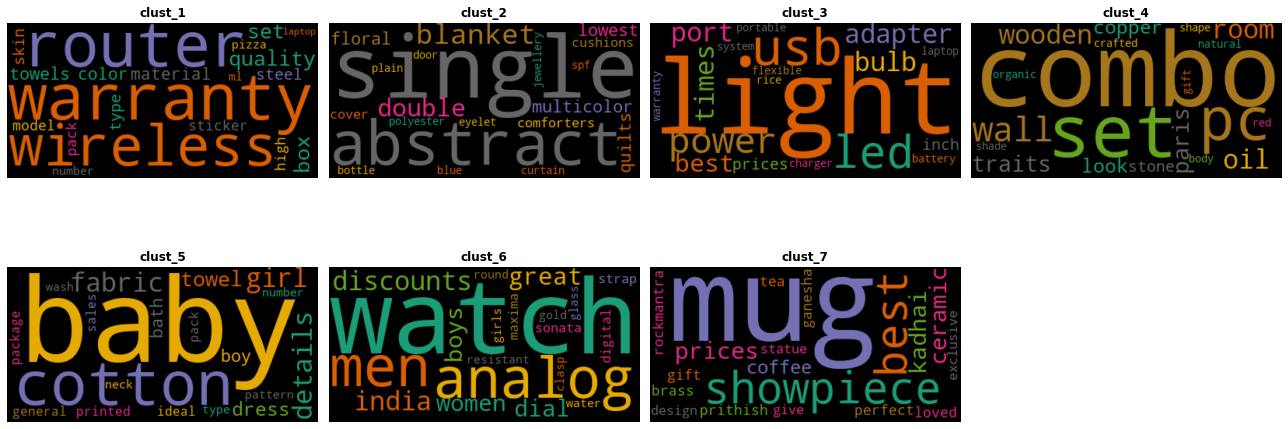

In [90]:
plot_wordclouds_topwords(H, n_top_words=20, n_rows=2)

In [91]:
# printing 10 top words for each topic
for i in H.index:
    print(i, '---', H.loc[i].sort_values(ascending=False)[0:10].index.tolist())
    print(i, '---',
          np.round(H.loc[i].sort_values(ascending=False)[0:10].values.tolist(),2))

clust_1 --- ['warranty', 'router', 'wireless', 'quality', 'set', 'box', 'towels', 'color', 'material', 'steel']
clust_1 --- [10.75 10.51  9.66  9.2   8.61  8.21  8.01  8.01  7.84  7.84]
clust_2 --- ['single', 'abstract', 'blanket', 'double', 'multicolor', 'floral', 'lowest', 'quilts', 'comforters', 'cover']
clust_2 --- [14.91 14.32 14.27 12.61 11.31  9.44  9.43  9.43  9.26  9.02]
clust_3 --- ['usb', 'led', 'light', 'power', 'adapter', 'port', 'bulb', 'times', 'best', 'prices']
clust_3 --- [24.08 13.07  9.11  7.36  6.85  6.55  6.4   6.22  5.61  5.58]
clust_4 --- ['combo', 'set', 'pc', 'wall', 'wooden', 'room', 'oil', 'traits', 'paris', 'copper']
clust_4 --- [45.02 42.05  6.6   5.85  5.52  4.47  4.35  4.13  4.01  3.88]
clust_5 --- ['baby', 'cotton', 'girl', 'fabric', 'details', 'towel', 'dress', 'boy', 'bath', 'printed']
clust_5 --- [29.92 25.6  17.9  16.26 16.2  12.56 11.44 11.27 11.18 10.8 ]
clust_6 --- ['watch', 'analog', 'men', 'discounts', 'india', 'great', 'women', 'dial', 'boys', 

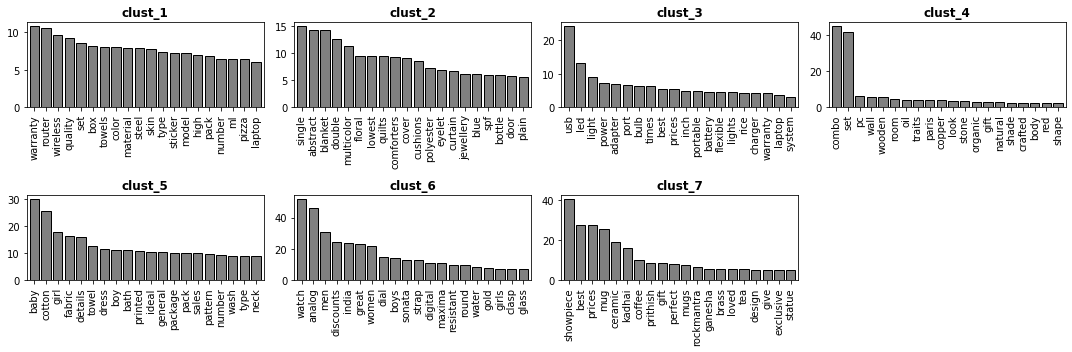

In [92]:
# plotting bar plots fo 20 top words for each topic
n_rows = 2
fig= plt.figure(figsize=(15,5))
for i, cat in enumerate(H.index, 1):
    n_tot = H.shape[0]
    n_cols = n_tot//n_rows + (n_tot%n_rows!=0)*1
    ax=fig.add_subplot(n_rows, n_cols, i)
    H.loc[cat].sort_values(ascending=False).iloc[0:20].plot.bar(color='grey',
                                                                width=0.8,
                                                                ec='k', ax=ax)
    ax.set_title(cat, fontweight='bold')
plt.tight_layout()
plt.show()

#### Most relevant items for each category

In [93]:
# 10 most relevant items for each categories
categories = ['clust_'+str(i) for i in range(1,8)]
for cat in categories:
    ser = W.loc[:,cat].sort_values(ascending=False)[0:3]
    print('-'*20+cat.upper()+'-'*20)
    display(df_desc_cat.loc[ser.index, ['product_name', 'description']])

--------------------CLUST_1--------------------


,product_name,description
uniq_id,,
156bcd3aba1838a2b6bad856654db964,Timewel N1536(GW)_1 Analog Watch - For Men,Timewel N1536(GW)_1 Analog Watch - For Men - Buy Timewel N1536(GW)_1 Analog Watch - For Men N...
64247967cbf6cd8bb2e243ac53aa5928,HMT HMTWHQ Analog Watch - For Men,HMT HMTWHQ Analog Watch - For Men - Buy HMT HMTWHQ Analog Watch - For Men HMTWHQ Online at Rs...
4019ad332ca3ce22449ff54fdd49a273,Timewel 1100-N1685 Analog Watch - For Men,Timewel 1100-N1685 Analog Watch - For Men - Buy Timewel 1100-N1685 Analog Watch - For Men 110...


--------------------CLUST_2--------------------


,product_name,description
uniq_id,,
a231459c1562ee1117e95a61128820b7,"Denver Cool,Honour Combo Set","Flipkart.com: Buy Denver Cool,Honour Combo Set online only for Rs. 350 from Flipkart.com. Only G..."
9a02f44389bda4c60e7dc23947dbca58,Playboy London And Berlin Combo Set,Flipkart.com: Buy Playboy London And Berlin Combo Set online only for Rs. 388 from Flipkart.com....
91e22428c0dd8871288ba5dac35a7382,Spinz Combo Set,Flipkart.com: Buy Spinz Combo Set online only for Rs. 354 from Flipkart.com. Only Genuine Produc...


--------------------CLUST_3--------------------


,product_name,description
uniq_id,,
7ee2e665b7de2e1cc29e3c65bde0c318,Mavi 237MBB Showpiece - 15 cm,Buy Mavi 237MBB Showpiece - 15 cm for Rs.1290 online. Mavi 237MBB Showpiece - 15 cm at best ...
7729e54756a60aecb2067a747c890913,Golmaalshop Showpiece - 12.7 cm,Buy Golmaalshop Showpiece - 12.7 cm for Rs.649 online. Golmaalshop Showpiece - 12.7 cm at be...
0f7a56876c61ba98dfed48ede5d3f3e1,Ruchikainternational ruc0013 Showpiece - 13 cm,Buy Ruchikainternational ruc0013 Showpiece - 13 cm for Rs.549 online. Ruchikainternational ruc...


--------------------CLUST_4--------------------


,product_name,description
uniq_id,,
302c95f6eae5f4ce217fcedc4ef91262,Rastogi Handicrafts Showpiece - 20 cm,Buy Rastogi Handicrafts Showpiece - 20 cm for Rs.450 online. Rastogi Handicrafts Showpiece - ...
9833d0de7f7e1927c807411c10b19189,Ruchikainternational ruc0015 Showpiece - 4 cm,Buy Ruchikainternational ruc0015 Showpiece - 4 cm for Rs.499 online. Ruchikainternational ruc0...
a554abb9699959ec78425eac2b997c27,NEHP NEH0012 Showpiece - 22.86 cm,Buy NEHP NEH0012 Showpiece - 22.86 cm for Rs.699 online. NEHP NEH0012 Showpiece - 22.86 cm a...


--------------------CLUST_5--------------------


,product_name,description
uniq_id,,
f8794f7a06b530782c66f7c0911bb437,Rockmantra Fantasy ArtRMMW50000330 Ceramic Mug,Rockmantra Fantasy ArtRMMW50000330 Ceramic Mug (5.5 l)\r\n Price: Rs. 19...
8bf65b132179faf26f61e26274b2b819,Rockmantra Gamming Wallpaper Ceramic Mug,Rockmantra Gamming Wallpaper Ceramic Mug (5.5 l)\r\n Price: Rs. 349\r\n\...
3847353a4b8de1efc504d589aea74ffe,Rockmantra Tele PhoneRMMW50000160 Ceramic Mug,Rockmantra Tele PhoneRMMW50000160 Ceramic Mug (5.5 l)\r\n Price: Rs. 199...


--------------------CLUST_6--------------------


,product_name,description
uniq_id,,
60a7313ea1e0ee8d845a0a6dec6117cc,Zingalalaa LP-50 50 lm LED Corded Portable Projector,Specifications of Zingalalaa LP-50 50 lm LED Corded Portable Projector (Multicolor) Performance ...
7fd3f7b35e8b4a66432c974c8cb5c46d,PRINT SHAPES doraemon Laptop Skin with Mouse pad Combo Set,Specifications of PRINT SHAPES doraemon Laptop Skin with Mouse pad Combo Set (Multicolor) Genera...
5bc04e6a0b6256dc78bb9cb22b39ef41,APOLLO+ Pack Of 3 Flexible Led Light,Key Features of APOLLO+ Pack Of 3 Flexible Led Light System Requirements: USB Port V1.1 Material...


--------------------CLUST_7--------------------


,product_name,description
uniq_id,,
e86daf9ebcdfc5c5dd088cdb7f8f8db6,Epresent Mfan 1 Fan USB USB Fan,Buy Epresent Mfan 1 Fan USB USB Fan for Rs.219 online. Epresent Mfan 1 Fan USB USB Fan at best p...
c612bdfa459e1e2f20d57348336c24be,QP360 Kid Fan 01 MLY2015 USB USB Fan,Buy QP360 Kid Fan 01 MLY2015 USB USB Fan for Rs.489 online. QP360 Kid Fan 01 MLY2015 USB USB Fan...
00ed03657cedbe4663eff2d7fa702a33,"Crystle Crystle01 CRSTL - Bluecensor USB Led Light, USB Cable","Buy Crystle Crystle01 CRSTL - Bluecensor USB Led Light, USB Cable for Rs.199 online. Crystle Cry..."


In [94]:
# Appending the best results of the LDA topics modeling 
df_res_clust['LSA_tfidf'] = W.idxmax(1)

In [95]:
df_res_clust.sample(5)

,categories,NMF_tfidf,LDA_tfidf,LSA_tfidf
uniq_id,,,,
e921fc17a0ed9a58f76d38558deb9337,Decor,clust_6,clust_1,clust_3
9d279c825ba12804c337f883b366a6e2,Decor,clust_6,clust_1,clust_2
788dc3a3da91c0f46a7c465e07f91dd4,Watches,clust_1,clust_6,clust_1
3ba13df7877fd979d64c87c7586a5ca6,Decor,clust_6,clust_3,clust_3
e426290a8f57e82680275bb91df91ad1,Computers,clust_7,clust_3,clust_7


### 5.4 KMeans Clustering

#### Clustering on BOW and TF-IDF matrices

In [96]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

Preprocessing and vectorization of the data

In [97]:
# Vectorization of the descriptions prior to projection on Wiki2Vec

tf_idf_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None},
                         vec_params = {'min_df': 10,
                                       'stop_words': sw},
                         tfidf_on=True)

In [98]:
# Fitting the Kmeans model
km.fit(tf_idf_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [99]:
# Appending the best results of the Kmeans clustering
df_res_clust['KMclust_tfidf'] = km.labels_

In [100]:
df_res_clust.sample(5)

,categories,NMF_tfidf,LDA_tfidf,LSA_tfidf,KMclust_tfidf
uniq_id,,,,,
afc829d45be38102afaa20f4bce2f627,Beauty,clust_6,clust_1,clust_6,6
a371cfcae8c6ec3b82ae37a83a8ae9b9,Furnishing,clust_6,clust_4,clust_6,0
6e6694c52c9273cde2163d34d5b44e94,Decor,clust_6,clust_3,clust_3,6
8aa19c1f26ee1f256d4c3ab5f2f849be,Watches,clust_1,clust_6,clust_1,3
7ee2e665b7de2e1cc29e3c65bde0c318,Decor,clust_3,clust_7,clust_3,1


#### Clustering on Word2vec embedding

#### Clustering on NMF selected features

#### Clustering on LDA selected features

### 5.5 Comparison of clusters labels with true categories

#### ARI scores (true categories vs. clusters)

In [101]:
from sklearn.metrics import adjusted_rand_score

In [102]:
df_res_clust.columns

Index(['categories', 'NMF_tfidf', 'LDA_tfidf', 'LSA_tfidf', 'KMclust_tfidf'], dtype='object')

In [103]:
adjusted_rand_score(df_res_clust['categories'],
                    df_res_clust['NMF_tfidf'])

0.32450356573217576

In [104]:
ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 4 others ---
ARI: mean=0.311, std=0.034, min=0.258, max=0.352 


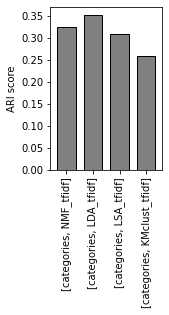

In [105]:
fig = plt.figure(figsize=(2,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Confusion matrix

In [107]:
from sklearn.preprocessing import FunctionTransformer
from scipy.optimize import linear_sum_assignment

def confusion_matrix_clust(true_cat, clust_lab, normalize=False,
                           margins_sums=False, margins_score=False):

    ### Count the number of articles in eact categ/clust pair
    cross_tab = pd.crosstab(true_cat, clust_lab,
                         normalize=normalize)

    ### Rearrange the lines and columns to maximize the diagonal values sum
    # Take the invert values in the matrix
    func = lambda x: 1/(x+0.0000001)
    inv_func = lambda x: (1/x) - 0.0000001
    funct_trans = FunctionTransformer(func, inv_func)
    inv_df = funct_trans.fit_transform(cross_tab)

    # Use hungarian algo to find ind and row order that minimizes inverse
    # of the diag vals -> max diag vals
    row_ind, col_ind = linear_sum_assignment(inv_df.values)
    inv_df = inv_df.loc[inv_df.index[row_ind],
                        inv_df.columns[col_ind]]

    # Take once again inverse to go back to original values
    cross_tab = funct_trans.inverse_transform(inv_df)
    result = cross_tab.copy(deep='True')

    if normalize == False:
        result = result.round(0).astype(int)

    if margins_sums:
        # assign the sums margins to the result dataframe
        marg_sum_vert = result[result.columns].sum(1)
        result = result.assign(cat_sum=marg_sum_vert)
        marg_sum_hor = result.loc[result.index].sum(0)
        result = result.append(pd.Series(marg_sum_hor,
                                         index=result.columns,
                                         name='clust_sum'))

    if margins_score:
        # Compute a correpondance score between clusters and categories
        li_cat_clust = list(zip(cross_tab.index,
                                cross_tab.columns))
        li_cat_corresp_score, li_clust_corresp_score = [], []
        for i, tup in enumerate(li_cat_clust):
            match = result.loc[tup]
            cat_corr_score = 100*match/cross_tab.sum(1).iloc[i]
            clust_corr_score = 100*match/cross_tab.sum(0).iloc[i]
            li_cat_corresp_score.append(cat_corr_score)
            li_clust_corresp_score.append(clust_corr_score)

        # assign the margins to the result dataframe
        if margins_sums:
            li_cat_corresp_score.append('-')
            li_clust_corresp_score.append('-')

        marg_vert = pd.Series(li_cat_corresp_score,
                              index=result.index,
                              name='cat_matching_score_pct')
        result = result.assign(cat_matching_score_pct=marg_vert) 

        marg_hor = pd.Series(li_clust_corresp_score + ['-'],
                             index=result.columns,
                             name='clust_matching_score_pct')
        result = result.append(marg_hor)

    result = result.fillna('-')

    return result

In [108]:
cat_clust_confmat = confusion_matrix_clust(df_res_clust['categories'],
                                           df_res_clust['NMF_tfidf'],
                                           normalize=False,
                                           margins_sums=True,
                                           margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

NMF_tfidf,clust_4,clust_2,clust_7,clust_3,clust_6,clust_5,clust_1,cat_sum,cat_matching_score_pct
categories,,,,,,,,,
Baby,95,5,0,14,32,2,2,150,63
Beauty,1,78,0,30,40,0,1,150,52
Computers,0,0,62,0,64,0,24,150,41
Decor,0,3,1,77,65,1,3,150,51
Furnishing,14,5,0,0,131,0,0,150,87
Kitchen,0,2,7,24,42,75,0,150,50
Watches,0,0,0,0,3,0,147,150,98
clust_sum,110,93,70,145,377,78,177,1050,-
clust_matching_score_pct,86,84,89,53,35,96,83,-,-


#### 2D visualisation

In [109]:
df_res_clust.iloc[:,0:2].sample()

,categories,NMF_tfidf
uniq_id,,
41ae5a7304f3dc1dc8bc2dfc7765ae4d,Watches,clust_1


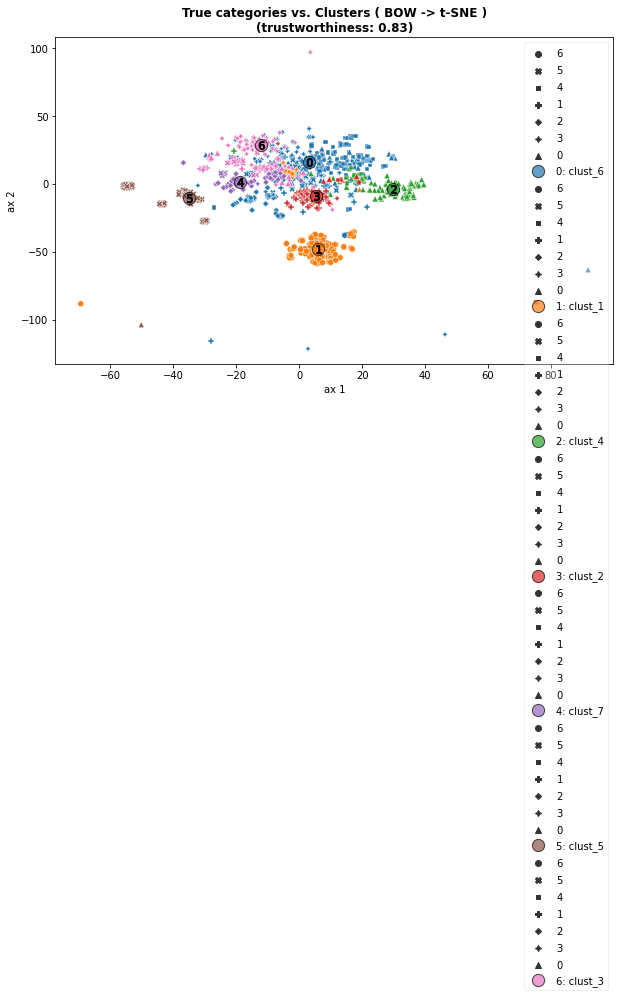

In [114]:
# Plotting a projection of the points (true categories vs. clusters) (PCA 0.71, UMAP 0.81, t-SNE 0.83)

plot_projection2(CV_TD_df,
                 model=None, ser_clust=df_res_clust['NMF_tfidf'], # clustering already done
                 true_cat=df_res_clust['categories'],
                 proj='t-SNE', size=50, legend_on=True,
                 title="True categories vs. Clusters ( BOW -> t-SNE )",
                 figsize=(10, 6), palette='tab10',
                 fig=None, ax=None, random_state=14)

- calcul de la pertinence des catégories trouvées par rapport aux catégories initiales et représentation graphique

- optimisation du nombre de catégories par mesure de la cohérence des mots les plus représentatifs de chaque catégorie (nécessite d'entraîner un modèle word2vec)
- représentation des catégories (des mots les plus représentatifs qui les composent) avec t-SNE
- essai direct de clustering sur la représentation des mots par Word2Vec

- Latent Dirichlet Allocation pour trouver d'autres clusters

- comment mettre en place un vote permettant d'aggréger le résultat de plusieurs clusterings différents lorsque les catégories n'ont pas les mêmes numéros ? 

### FUNCTIONS

- Ajouter les clusters (autre forme de marqueurs)
- Tracer les centroïdes des clusters
- Trouver une correspondance entre les clusters et les catégories
- une ligne qui relie les clusters

In [111]:
true_cat=df_res_clust['categories']

In [112]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
lenc.fit_transform(true_cat).shape

(1050,)

In [113]:
''' Plots the points on two axis (projection choice available : PCA, UMAP, t-SNE)
with clusters coloring if model available (grey if no model given).
NB: if the model wa already fitted, does not refit.'''

import seaborn as sns
from sklearn.manifold import trustworthiness
from sklearn.preprocessing import LabelEncoder

def plot_projection2(df, model=None, ser_clust = None, true_cat=None,
                     proj='PCA', title=None, figsize=(5, 3), size=1,
                     palette='tab10', legend_on=False,
                     fig=None, ax=None, random_state=14):

    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    # a1 - if model : computes clusters, clusters centers and plot with colors
    if model is not None:

        # Computes the axes for projection with centers
        # (uses fitted model if already fitted)
        dict_proj, dict_proj_centers, model = prepare_2D_axes(df,
                                                              proj=[proj],
                                                              model=model,
                                                              centers_on=True,
                                                              random_state=random_state)

        # ...or using model already fitted in prepare_2D_axes to get it
        #### all clusterers don't have .predict/labels_ method -> changed
        if hasattr(model, 'labels_'):
            clust = model.labels_
        else:
            clust = model.predict(df)
        ser_clust = pd.Series(clust,
                                index=df.index,
                                name='Clust')
        
    # a2 - if no model but ser_clust is given, plot with colors
    elif ser_clust is not None:
        
        # Computes the axes for projection
        dict_proj, dict_proj_centers, _ = \
            prepare_2D_axes(df, ser_clust=ser_clust, proj=[proj],
                            model=None, centers_on=True,
                            random_state=random_state)

        n_clust = ser_clust.nunique()
        colors = sns.color_palette(palette, n_clust).as_hex()

    # b1 - if ser_clust exists (either calculated from model or given)
    if ser_clust is not None:

        # Showing the points, cluster by cluster
        # for i in range(n_clust):
        lenc = LabelEncoder()
        markers = pd.Series([f'${i}$' for i in lenc.fit_transform(true_cat)],
                          index=true_cat.index)

        for i, name_clust in enumerate(ser_clust.unique()):
            ind = ser_clust[ser_clust == name_clust].index
            # ax.scatter(dict_proj[proj].loc[ind].iloc[:, 0],
            #            dict_proj[proj].loc[ind].iloc[:, 1],
            #            s=size, markers=markers.loc[ind],
            #            alpha=0.7, c=colors[i], zorder=1)
            sns.scatterplot(x=dict_proj[proj].loc[ind].iloc[:, 0],
                        y=dict_proj[proj].loc[ind].iloc[:, 1],
                        color=colors[i], sizes=size,  style=markers, # markers=markers, size=size,
                    #    data=None, palette=None, hue_order=None, hue_norm=None,
                    #     size_order=None, size_norm=None, hue=None,
                    #    style_order=None, x_bins=None, y_bins=None, units=None,
                    #    estimator=None, ci=95, n_boot=1000, alpha=None,
                       legend='auto', ax=ax)

            # Showing the clusters centers
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].loc[name_clust],
                        dict_proj_centers[proj].iloc[:, 1].loc[name_clust],#.values[i],
                        marker='o', c=colors[i], alpha=0.7, s=150,
                       edgecolor='k',
                       label=f"{i}: {name_clust}", zorder=10)
            # Showing the clusters centers labels (number)
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].loc[name_clust],#.values[i],
                        dict_proj_centers[proj].iloc[:, 1].loc[name_clust],
                        marker=r"$ {} $".format(i),#
                        c='k', alpha=1, s=70, zorder=100)
            if legend_on:
                plt.legend()
                ax.legend().get_frame().set_alpha(0.3)


    # b2 - if no ser_clust: only plot points in grey
    else:
        # Computes the axes for projection without centers
        dict_proj = prepare_2D_axes(df,
                                    proj=[proj],
                                    centers_on=False,
                                    random_state=random_state)
        # Plotting the point in grey
        ax.scatter(dict_proj[proj].iloc[:, 0],
                   dict_proj[proj].iloc[:, 1],
                   s=size, alpha=0.7, c='grey')
        

    # Computing the trustworthiness
    trustw = trustworthiness(df, dict_proj[proj],
                             n_neighbors=5, metric='euclidean')

    title = "Projection: " + proj + "(trustworthiness: {:.2f})".format(trustw)\
             if title is None else title
    ax.set_title(title + "\n(trustworthiness: {:.2f})".format(trustw), fontsize=12, fontweight='bold')
    ax.set_xlabel('ax 1'), ax.set_ylabel('ax 2')

## Exportation

Now we export the dataset of aggregated orders in a .csv file.

In [ ]:
dfs['ord_it'].to_csv('agg_order_items.csv')